In [1]:
from pathlib import Path
import pyvista as pv
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cm
import subprocess
import os
from scipy.interpolate import griddata

filepath = Path('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/02_CODE/src/hfe_utils/plot_strain_fields.ipynb')

Available point data arrays in vtkpv: ['RF', 'RM', 'U', 'UR']
Available cell data arrays in vtkpv: ['COORD_Centroid', 'COORD_IntegrationPoints', 'LE_Centroid', 'LE_IntegrationPoints', 'S_Centroid', 'S_IntegrationPoints', 'SDV_BVTVC_Centroid', 'SDV_BVTVC_IntegrationPoints', 'SDV_BVTVT_Centroid', 'SDV_BVTVT_IntegrationPoints', 'SDV_DMG_Centroid', 'SDV_DMG_IntegrationPoints', 'SDV_F11_Centroid', 'SDV_F11_IntegrationPoints', 'SDV_F12_Centroid', 'SDV_F12_IntegrationPoints', 'SDV_F13_Centroid', 'SDV_F13_IntegrationPoints', 'SDV_F21_Centroid', 'SDV_F21_IntegrationPoints', 'SDV_F22_Centroid', 'SDV_F22_IntegrationPoints', 'SDV_F23_Centroid', 'SDV_F23_IntegrationPoints', 'SDV_F31_Centroid', 'SDV_F31_IntegrationPoints', 'SDV_F32_Centroid', 'SDV_F32_IntegrationPoints', 'SDV_F33_Centroid', 'SDV_F33_IntegrationPoints', 'SDV_OFVALUE_Centroid', 'SDV_OFVALUE_IntegrationPoints', 'SDV_PBVC_Centroid', 'SDV_PBVC_IntegrationPoints', 'SDV_PBVT_Centroid', 'SDV_PBVT_IntegrationPoints', 'Material_Orientation', 

/Users/msb/opt/anaconda3/envs/testing/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


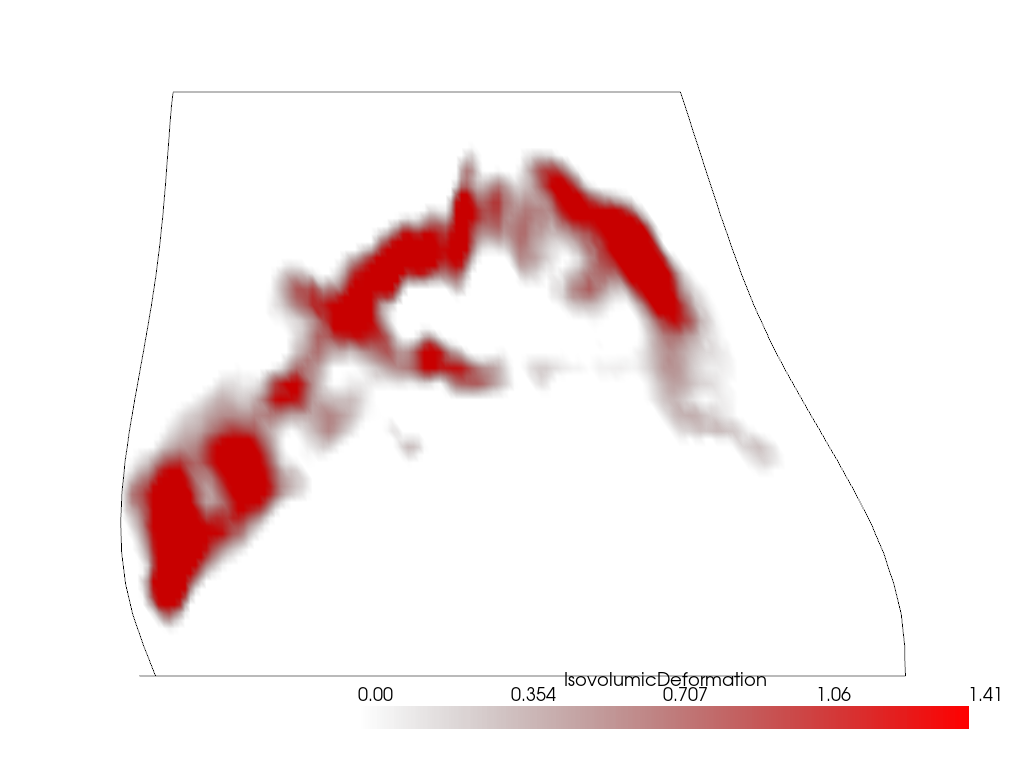

In [5]:
def plot_midslice_vtk(vtkpath: Path, celldata: str):
    def custom_colormap():
        # Create a custom colormap
        cmap = colors.LinearSegmentedColormap.from_list(
            "transparent_to_red", [(0, 0, 0, 0), (1, 0, 0, 1)]
        )

        # norm = colors.Normalize(vmin=np.min(clip_masked[celldata]), vmax=np.max(clip_masked[celldata]))
        norm = colors.Normalize(vmin=np.quantile(sliced.point_data[celldata], 0.9), vmax=np.quantile(sliced.point_data[celldata], 0.99))
        color_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        return color_mapper, cmap

    def make_structured_grid(unstructured_grid, grid_size=200):
        bounds = unstructured_grid.bounds

        xx = np.linspace(bounds[0], bounds[1], grid_size)
        yy = np.linspace(bounds[2], bounds[3], grid_size)
        zz = np.linspace(bounds[4], bounds[5], grid_size//2)
        x, y, z = np.meshgrid(xx, yy, zz, indexing='ij')

        points = unstructured_grid.points

        # Check if 'IsovolumicDeformation' is point data or cell data
        if 'IsovolumicDeformation' in unstructured_grid.point_data:
            values = unstructured_grid.point_data['IsovolumicDeformation']
        elif 'IsovolumicDeformation' in unstructured_grid.cell_data:
            # Convert cell data to point data
            cell_values = unstructured_grid.cell_data['IsovolumicDeformation']
            point_values = unstructured_grid.cell_data_to_point_data().point_data['IsovolumicDeformation']
            values = point_values
        else:
            raise ValueError("IsovolumicDeformation not found in point data or cell data.")

        # Ensure that the points and values have the correct shape
        assert points.shape[0] == values.shape[0], "The number of points must match the number of values."

        # Interpolate the unstructured grid data onto the regular grid
        grid_values = griddata(points, values, (x, y, z), method='linear')
        grid_values = np.nan_to_num(grid_values)
        grid = pv.StructuredGrid(x, y, z)
        grid.point_data['IsovolumicDeformation'] = grid_values.flatten(order='F')

        return grid
    
    vtkpv = pv.read(vtkpath)
    
    # Print available point data and cell data arrays for debugging
    print("Available point data arrays in vtkpv:", vtkpv.point_data.keys())
    print("Available cell data arrays in vtkpv:", vtkpv.cell_data.keys())
    
    structured_grid = make_structured_grid(vtkpv, 150)
    print("Available point data arrays in structured_grid:", structured_grid.point_data.keys())

    sliced = structured_grid.clip(normal=[1,0,0], invert=True)
    outline_pv = vtkpv.clip(normal=[1,0,0], invert=True)

    # Print available point data arrays for debugging
    print("Available point data arrays in sliced:", sliced.point_data.keys())

    clip_masked = sliced.threshold(
        [np.quantile(sliced.point_data[celldata], 0), np.quantile(sliced.point_data[celldata], 1.0)],
        scalars=celldata, invert=False)

    color_mapper, cmap = custom_colormap()
    clip_masked['IsovolumicDeformation_Colors'] = color_mapper.to_rgba(clip_masked[celldata])


    edges = outline_pv.extract_feature_edges(65)

    p = pv.Plotter(notebook=True, off_screen=False)
    p.add_mesh(edges, color='black', lighting=False)
    p.add_mesh(
        clip_masked,
        scalars='IsovolumicDeformation_Colors',
        cmap=cmap,
        show_edges=False,
        log_scale=False,
        scalar_bar_args={"title": celldata, "n_labels": 5},
    )
    p.view_zy()
    p.camera.roll += 270
    p.camera.SetParallelProjection(True)
    p.camera.zoom(1.4)
    p.show()
    # name_with_celldata = vtkpath.stem + '_' + celldata
    # vtk_parent_path = vtkpath.parent / 'midslice'
    # vtk_parent_path.mkdir(parents=True, exist_ok=True)
    # p.screenshot(vtk_parent_path / f'{name_with_celldata}.png')


vtkpath = r'/Users/msb/Desktop/C0003101_MESH.vtu'

celldata = 'IsovolumicDeformation'
plot_midslice_vtk(Path(vtkpath), celldata)

In [ ]:
sim_results_path = Path(r'/home/simoneponcioni/Documents/01_PHD/04_Output-Reports-Presentations-Publications/HFE-RESULTS/strain-distribution/20240501/midslice')
exp_results_path = Path(r'/home/simoneponcioni/Documents/01_PHD/04_Output-Reports-Presentations-Publications/HFE-RESULTS/strain-distribution/FRACTIB-publication/')

isovolumic_dict = {}
spherical_dict = {}
for sim_img in sim_results_path.rglob('*.png'):
    sim_name = sim_img.stem.split('_')[0]
    exp_img = exp_results_path / f'{sim_name}_Reg.png'
    
    if "IsovolumicDeformation" in sim_img.stem:
        isovolumic_dict[sim_img] = exp_img
    elif "SphericalCompression" in sim_img.stem:
        spherical_dict[sim_img] = exp_img

# Sorting dictionaries by their keys and storing them as dictionaries again
isovolumic_dict = dict(sorted(isovolumic_dict.items(), key=lambda item: item[0]))
spherical_dict = dict(sorted(spherical_dict.items(), key=lambda item: item[0]))

import pprint
pprint.pprint(isovolumic_dict)

In [ ]:
beamer_isovolumic = sim_results_path / 'beamer_isovolumic_deformation.tex'
beamer_spherical = sim_results_path / 'beamer_spherical_compression.tex'
for beamer_presentation, coupling_dict in zip([beamer_isovolumic, beamer_spherical], [isovolumic_dict, spherical_dict]):
    with open(beamer_presentation, 'w') as f:
        # Write the preamble
        f.write("\\documentclass{beamer}\n\\usepackage{graphicx}\n\\begin{document}\n")

        # Iterate over the dictionary
        for sim_img, exp_img in coupling_dict.items():
            # Replace underscores in the file paths
            sim_img_latex = str(sim_img).replace("_", "\\_")
            exp_img_latex = str(exp_img).replace("_", "\\_")
            
            sim_name = str(sim_img.name).replace("_", "\\_")
            exp_name = str(exp_img.name).replace("_", "\\_")

            # Write the LaTeX code for the slide
            f.write("\\begin{frame}\n")
            f.write("\\begin{columns}\n")
            
            f.write("\\begin{column}{0.5\\textwidth}\n")
            f.write("\\begin{figure}\n")
            f.write("\\includegraphics[width=\\textwidth]{" + sim_img_latex + "}\n")
            f.write("\\caption{" + sim_name + "}\n")  # Add caption for the sim_img
            f.write("\\end{figure}\n")
            f.write("\\end{column}\n")
            
            f.write("\\begin{column}{0.5\\textwidth}\n")
            f.write("\\begin{figure}\n")
            f.write("\\includegraphics[width=\\textwidth]{" + exp_img_latex + "}\n")
            f.write("\\caption{" + exp_name + "}\n")  # Add caption for the exp_img
            f.write("\\end{figure}\n")
            f.write("\\end{column}\n")
            
            f.write("\\end{columns}\n")
            f.write("\\end{frame}\n")

        # Write the end of the document
        f.write("\\end{document}\n")

    # Call pdflatex to compile the .tex file to a .pdf
    os.chdir(sim_results_path)
    subprocess.run(['pdflatex', str(beamer_presentation)], check=True)
    os.chdir(filepath.parent)